<a href="https://colab.research.google.com/github/pevu97/Aerial-Object-Classifier/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory

np.set_printoptions(precision=6, suppress=True)

In [5]:
!wget https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5

--2025-06-25 11:31:53--  https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G) [application/octet-stream]
Saving to: ‘Galaxy10_DECals.h5.1’

Galaxy10_DECals.h5. 100%[===================>]   2.55G  10.7MB/s    in 3m 10s  

2025-06-25 11:35:04 (13.8 MB/s) - ‘Galaxy10_DECals.h5.1’ saved [2735267419/2735267419]



In [60]:
import h5py
import numpy as np
from tensorflow.keras.utils import to_categorical

with h5py.File('Galaxy10_DECals.h5', 'r') as f:
    images = f['images'][:7000]     # tylko 1000 obrazów
    labels = f['ans'][:7000]        # tylko 1000 etykiet



images = images.astype('float32')


In [29]:
print("Kształt labels:", labels.shape)
print("Przykład:", labels[0])


Kształt labels: (7000, 10)
Przykład: [1 0 0 0 0 0 0 0 0 0]


In [ ]:
labels = np.argmax(labels, axis=1)

In [37]:

print(f"Kształt labels: {labels.shape}")
print(f"Przykład: {labels[1]}")

Kształt labels: (7000,)
Przykład: 0


In [38]:
import numpy as np

labels = labels.astype(int)

# oryginalne unikalne klasy:
unique_classes = np.unique(labels)
print("Zachowane klasy:", unique_classes)

# stworzenie mapowania np. {0: 0, 1: 1, 2: 2, 3: 3}
class_map = {old: new for new, old in enumerate(unique_classes)}
print("Mapowanie etykiet:", class_map)

# zastosowanie mapowania
labels_mapped = np.array([class_map[label] for label in labels])


Zachowane klasy: [0 1 2 3]
Mapowanie etykiet: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3}


In [62]:
print("Typ danych:", images[idx].dtype)
print("Zakres wartości:", images[idx].min(), "→", images[idx].max())
print("Kształt:", images[idx].shape)

Typ danych: float32
Zakres wartości: 0.0 → 255.0
Kształt: (256, 256, 3)


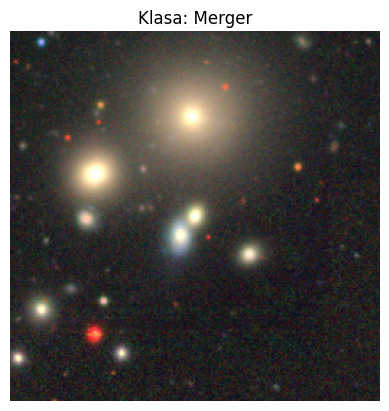

In [69]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    "Disturbed", "Merger", "Round Smooth", "In-between Smooth"
]


#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 2504 #@param {type:'slider', min:0, max:5999}
label_idx = labels_mapped[idx]
plt.imshow(images[idx].astype(np.uint8))  # obrazy są w formacie uint8
plt.title(f"Klasa: {class_names[label_idx]}")
plt.axis('off')
plt.show()

In [74]:
df_labels = pd.DataFrame(labels_mapped, columns=['Class number'])
df_labels['Class number'].value_counts()

,count
Class number,
2,2645
1,1853
3,1421
0,1081


In [75]:
import os
from PIL import Image
import numpy as np

# folder docelowy
output_dir = 'sorted_images'
os.makedirs(output_dir, exist_ok=True)

for i, (img, label) in enumerate(zip(images, labels_mapped)):
    label_dir = os.path.join(output_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)

    # zapisz obraz jako JPEG
    img_path = os.path.join(label_dir, f'image_{i:05d}.jpg')
    img_uint8 = img.astype(np.uint8)  # jeśli potrzebne
    Image.fromarray(img_uint8).save(img_path)


In [82]:
import os
import shutil
import random

def split_dataset(source_dir, output_dir, split=(0.7, 0.2, 0.1), seed=42):
    random.seed(seed)
    class_names = os.listdir(source_dir)

    for class_name in class_names:
        src_class_dir = os.path.join(source_dir, class_name)
        images = os.listdir(src_class_dir)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(split[0] * n_total)
        n_val   = int(split[1] * n_total)

        split_points = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, file_list in split_points.items():
            dest_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(dest_class_dir, exist_ok=True)

            for fname in file_list:
                shutil.copy2(os.path.join(src_class_dir, fname), os.path.join(dest_class_dir, fname))

# 🔁 Użycie:
split_dataset("sorted_images", "dataset", split=(0.7, 0.2, 0.1))
